In [ ]:
# setup and data loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the transaction data
# NOTE: Adjust the path if your VS Code setup has a different working directory.
try:
    df = pd.read_csv('../data/raw/data.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: data.csv not found. Please check the file path.")

# Load the variable definitions (optional, but good practice)
try:
    var_defs = pd.read_csv('../data/raw/Xente_Variable_Definitions.csv')
except FileNotFoundError:
    var_defs = None

# Set visual style for better plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Data loaded successfully.


In [2]:
print("--- Data Shape (Rows, Columns) ---")
print(df.shape)
print("\n--- Data Information (Columns, Non-Null Counts, Dtypes) ---")
print(df.info())
print("\n--- First 5 Rows ---")
print(df.head())

--- Data Shape (Rows, Columns) ---
(95662, 16)

--- Data Information (Columns, Non-Null Counts, Dtypes) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionSt

In [3]:
print("--- Descriptive Statistics for Numerical Features ---")
print(df.describe())

print("\n--- Value Counts for Key Categorical Features (Top 10) ---")
# Use the .nunique() to identify columns that are identifiers vs. true categories
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    if df[col].nunique() < 50: # Only look at columns with fewer than 50 unique values
        print(f"\n{col}:")
        print(df[col].value_counts(normalize=True).head(10))

# Convert TransactionStartTime to datetime for better analysis
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
print("\nTransactionStartTime Range:")
print(f"Min Date: {df['TransactionStartTime'].min()}")
print(f"Max Date: {df['TransactionStartTime'].max()}")

--- Descriptive Statistics for Numerical Features ---
       CountryCode        Amount         Value  PricingStrategy   FraudResult
count      95662.0  9.566200e+04  9.566200e+04     95662.000000  95662.000000
mean         256.0  6.717846e+03  9.900584e+03         2.255974      0.002018
std            0.0  1.233068e+05  1.231221e+05         0.732924      0.044872
min          256.0 -1.000000e+06  2.000000e+00         0.000000      0.000000
25%          256.0 -5.000000e+01  2.750000e+02         2.000000      0.000000
50%          256.0  1.000000e+03  1.000000e+03         2.000000      0.000000
75%          256.0  2.800000e+03  5.000000e+03         2.000000      0.000000
max          256.0  9.880000e+06  9.880000e+06         4.000000      1.000000

--- Value Counts for Key Categorical Features (Top 10) ---

CurrencyCode:
CurrencyCode
UGX    1.0
Name: proportion, dtype: float64

ProviderId:
ProviderId
ProviderId_4    0.399208
ProviderId_6    0.357362
ProviderId_5    0.152014
ProviderId_1 

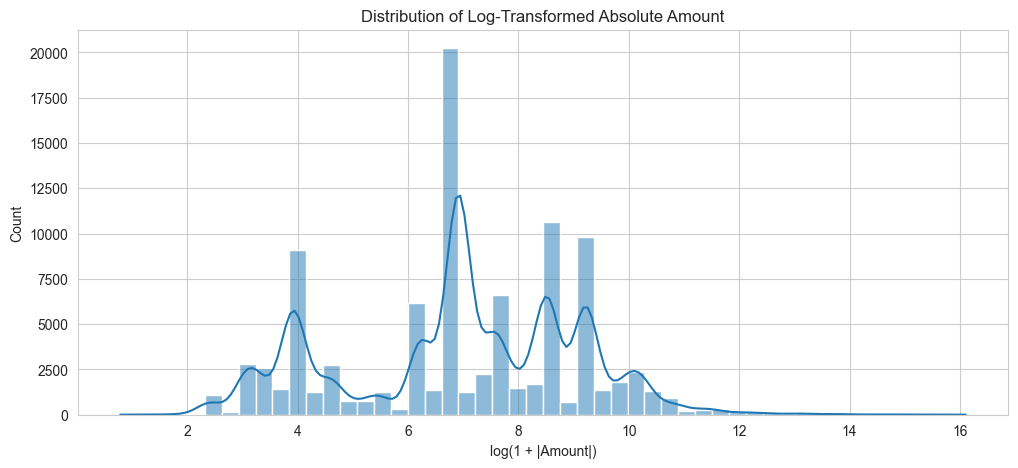

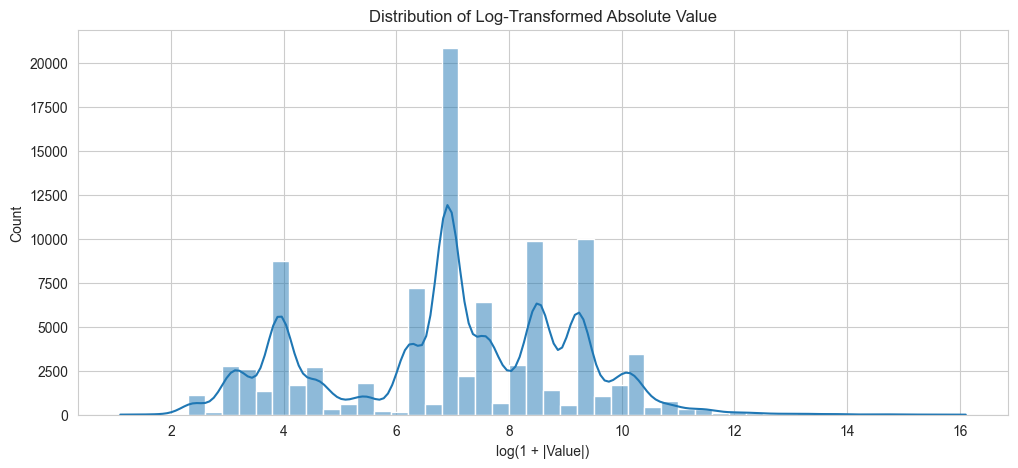

In [4]:
numerical_cols = ['Amount', 'Value']

for col in numerical_cols:
    plt.figure(figsize=(12, 5))

    # Log transformation for better visualization of skewed data
    sns.histplot(df[col].apply(lambda x: np.log1p(abs(x))), kde=True, bins=50)
    plt.title(f'Distribution of Log-Transformed Absolute {col}')
    plt.xlabel(f'log(1 + |{col}|)')
    plt.show()

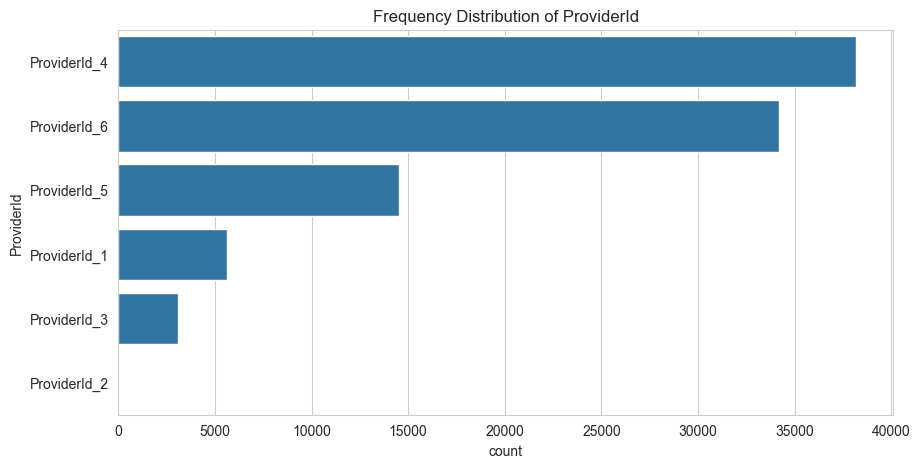

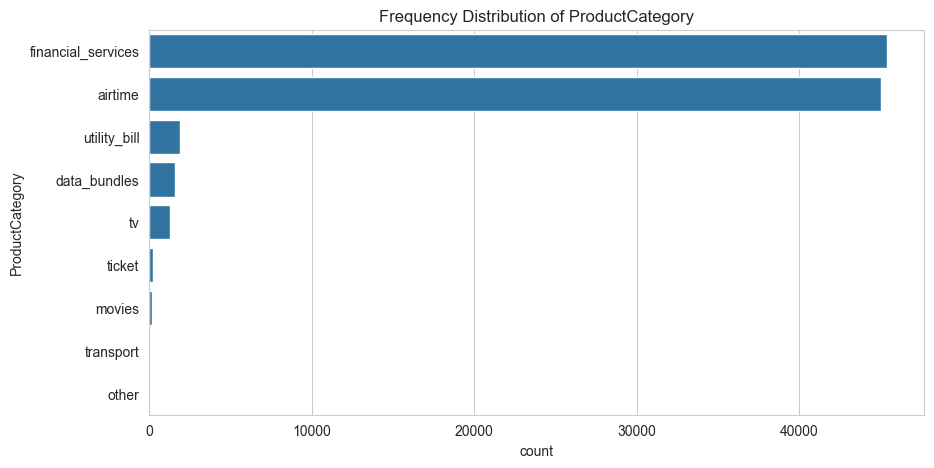

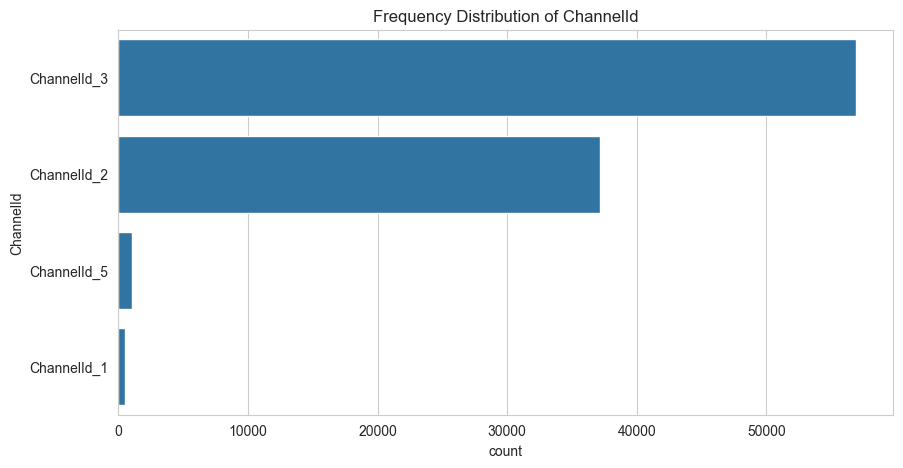

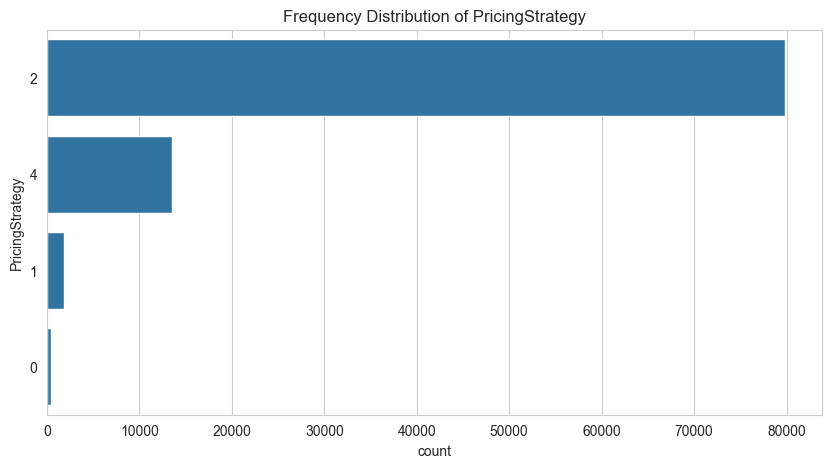

In [5]:
# Analyze frequency of a few key categorical columns
key_categorical_cols = ['Currency Code', 'ProviderId', 'ProductCategory', 'ChannelId', 'PricingStrategy', 'Fraud Result']

for col in key_categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(10, 5))
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Frequency Distribution of {col}')
        plt.show()

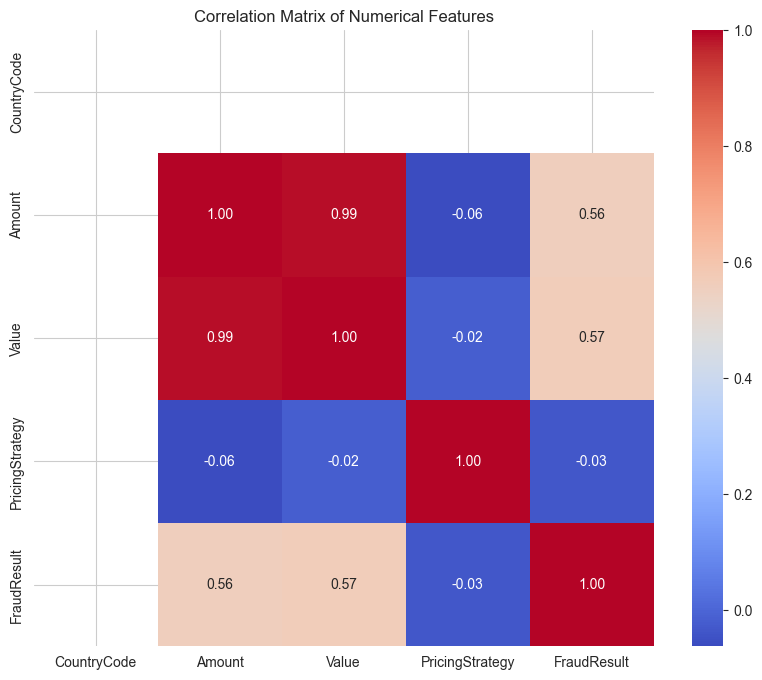

In [6]:
# Select only numerical features for correlation matrix
correlation_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [7]:
print("--- Missing Values Count and Percentage ---")
missing_info = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='Missing Count', ascending=False)

print(missing_info[missing_info['Missing Count'] > 0])

--- Missing Values Count and Percentage ---
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


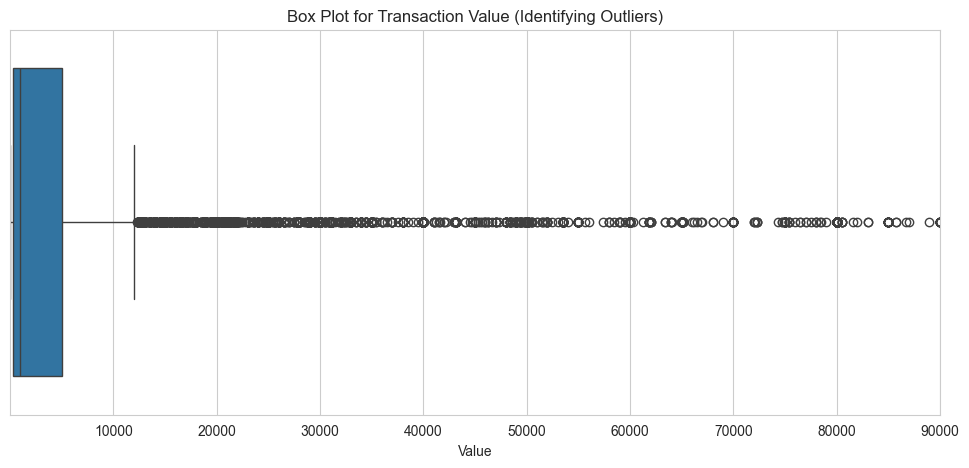

Value at 99th percentile: 90,000.00


In [8]:
# Focus on 'Value' as it is the absolute transaction amount
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['Value'])
plt.title('Box Plot for Transaction Value (Identifying Outliers)')
plt.xlim(df['Value'].min(), df['Value'].quantile(0.99)) # Zooming in for clarity
plt.show()

print(f"Value at 99th percentile: {df['Value'].quantile(0.99):,.2f}")

## Top 5 Important EDA Insights

Based on the initial Exploratory Data Analysis (EDA), the following insights are crucial for guiding the feature engineering and modeling stages of this project:

1.  **Data Quality is Excellent (No Missing Values):** The initial checks confirmed that the dataset contains **zero missing values** across all 16 columns. This eliminates the need for any complex imputation strategies, allowing us to proceed directly to feature creation.

2.  **Redundant and Constant Features Identified:** The `CountryCode` (constant 256) and `CurrencyCode` (constant 'UGX') have zero variance and provide no predictive value. These columns must be **excluded** from the final feature set.

3.  **Transaction Polarity and RFM Implications:** The `Amount` column contains both positive and negative values (min of -1,000,000), indicating the presence of both **debit** (money spent) and **credit/reversal** transactions. For robust RFM feature engineering, we must use the signed `Amount` to calculate separate Recency, Frequency, and Monetary metrics for the user's spending behavior versus their receiving/refunding behavior.

4.  **Extreme Skewness and Outliers:** Both `Amount` and `Value` are severely right-skewed. While the median transaction value is low (1,000), the maximum value is close to 9.88 million. Since the 99th percentile is only 90,000, these extreme outliers must be managed using methods like **log-transformation or Winsorizing** during data processing to stabilize the model.

5.  **Defined Temporal Window:** The transaction data spans a clear three-month period (November 2018 to February 2019). This provides a hard boundary for calculating **Recency** and **Frequency** components of the RFM framework, requiring a fixed "observation end date" (e.g., 2019-02-14) to correctly measure customer activity.